# Anomaly Detection

In [1]:
!pip install pandas numpy matplotlib seaborn scipy pyod

## Load data

In [2]:
import pandas as pd
df = pd.read_csv('data_predictive_maintenance.csv')
df['Type'] = df['Type'].map({'L': 1, 'M':2,'H':3})

## EDA
Show data

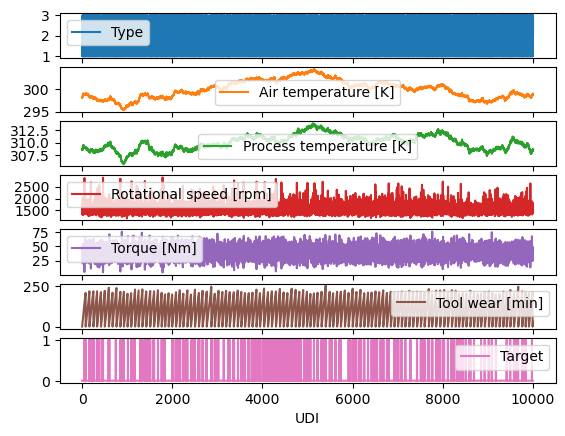

In [3]:
import matplotlib.pyplot as plt  

# showing dataset 
df.plot(x='UDI', kind='line', subplots=True) 
plt.show() 

In [4]:
df.columns

Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Target', 'Failure Type'],
      dtype='object')

In [5]:
df = df[['UDI', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Type', 'Target']]

In [6]:
# analysis of variance
df_std = df.std()
print(df_std) 

UDI                        2886.895680
Air temperature [K]           2.000259
Process temperature [K]       1.483734
Rotational speed [rpm]      179.284096
Torque [Nm]                   9.968934
Tool wear [min]              63.654147
Type                          0.671301
Target                        0.180981
dtype: float64


<Axes: >

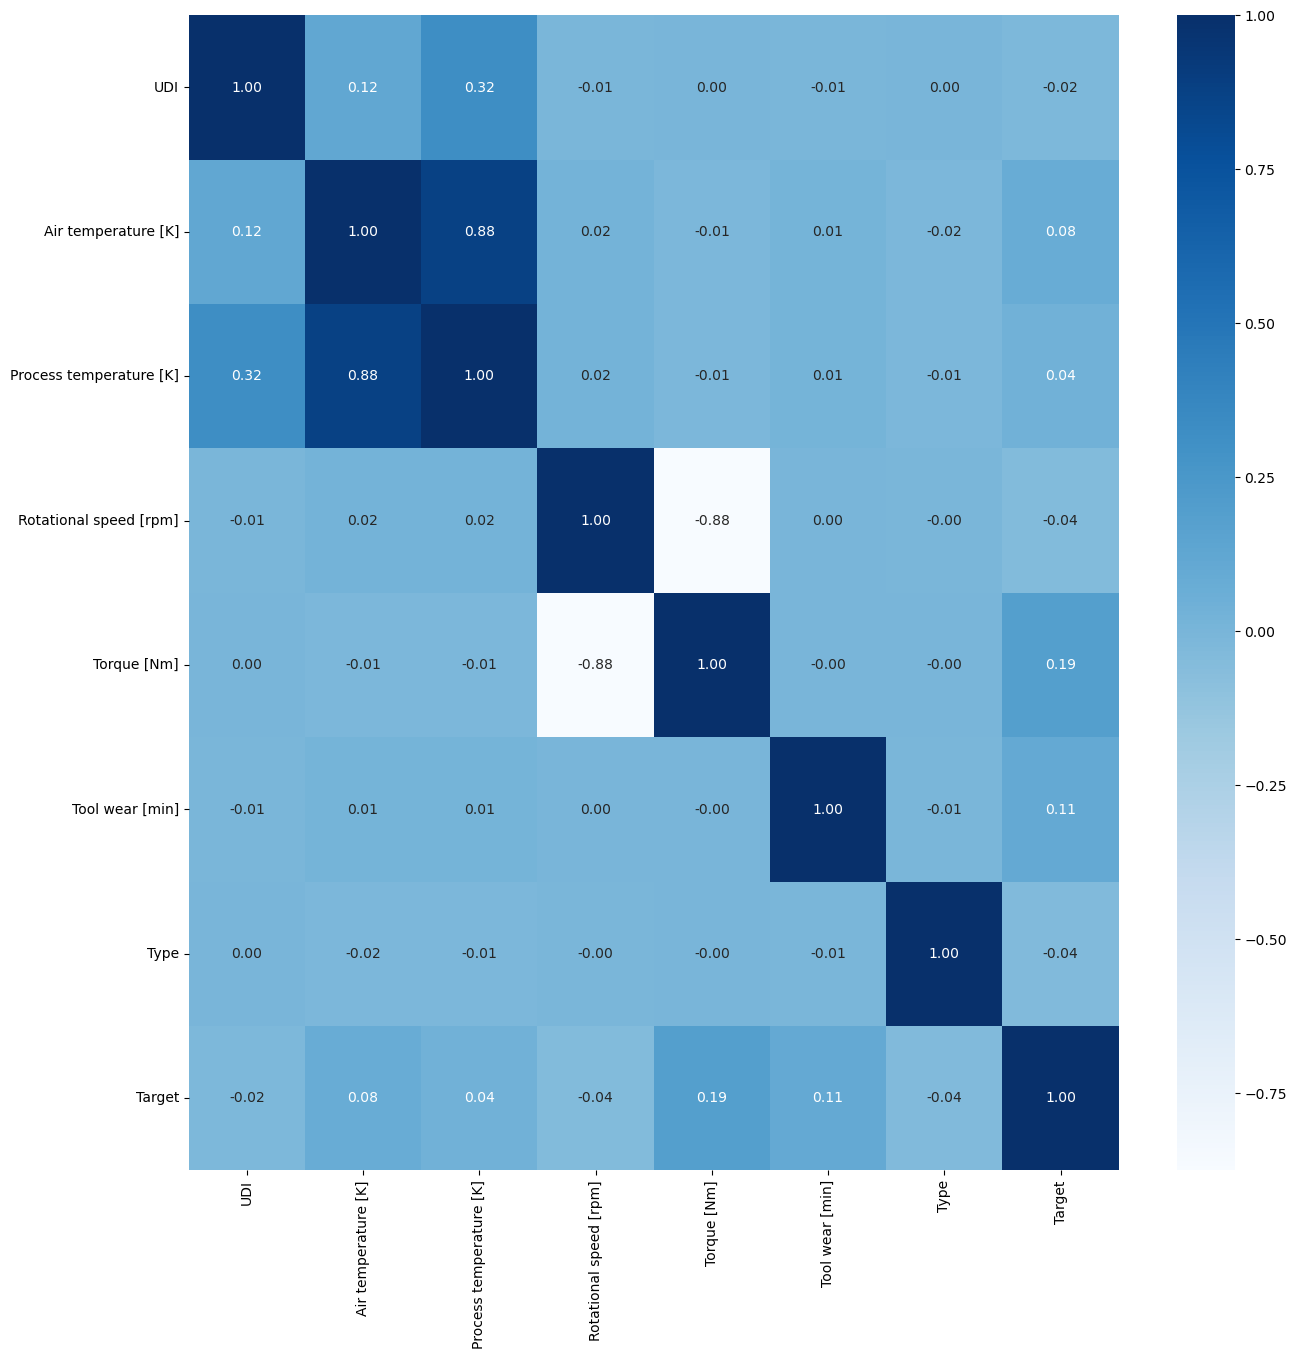

In [7]:
import matplotlib.pyplot as plt
from seaborn import heatmap
plt.figure(figsize=(15, 15))
heatmap(df.corr(),annot=True,cmap='Blues', fmt='.2f')

In [8]:
df['Diff temperature [K]'] = df['Air temperature [K]'] - df['Process temperature [K]']

In [9]:
# separate into input and output variables 
X_columns=['Air temperature [K]',
       'Diff temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Type']
X = df[X_columns].values
y = df[['Target']].values.flat

idx_split=8000
X_train, y_train = X[0:idx_split,:], y[0:idx_split]
X_test, y_test = X[idx_split:,:], y[idx_split:]

### Feature selection
USe RFE to select the most important varaible

In [10]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

# perform feature selection 
rfe = RFE(RandomForestRegressor(n_estimators=500, random_state=1))  
rfe = rfe.fit(X, y) 

In [11]:
# report selected features 
print('Selected Features:') 
names = df.columns.values[1:-1] 

for i in range(len(rfe.support_)): 
    if rfe.support_[i]: 
        print(names[i]) 

Selected Features:
Process temperature [K]
Rotational speed [rpm]
Torque [Nm]


# Build algorithm Moving average
* Moving average
* Id standard deviation is too high => anomaly

In [12]:
import numpy as np

def moving_average(data, window_size): 
    window = np.ones(int(window_size))/float(window_size)  
    return np.convolve(data, window, 'same') 

def search_anomalies(x, window_size, sigma=1.0): 
    avg = moving_average(x, window_size).tolist() 
    residual = x - avg 
    
    # Calculate the variation in the distribution of the residual 
    std = np.std(residual) 

    anomalies=[] 
    i=int(window_size)

    for y_i, avg_i in zip(x, avg): 
        if (y_i > avg_i + (sigma*std)) | (y_i < avg_i - (sigma*std)):  
            anomalies.append(1)
        else:
            anomalies.append(0)
    
    return np.array(anomalies)

In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
def show_anomalies(X_test, y_test, y_predicted, anomalous=1, title=''):
    t = np.array([i for i in range(len(y_test))]) 
    
    idx_predicted = y_predicted==anomalous
    idx_real = y_test==anomalous
    
    plt.figure(figsize=(10,5))
    plt.xlabel('samples')
    plt.ylabel(title)
    plt.plot(t,X_test,'tab:gray')
    plt.plot(t[idx_predicted], X_test[idx_predicted],'rD', label="predicted anomaly")
    plt.plot(t[idx_real],X_test[idx_real],'gX', label="real anomaly")
    plt.legend()
    plt.show()

    print('accuracy:',accuracy_score(idx_real,idx_predicted))
    print('confusion matrix:\n',confusion_matrix(idx_real,idx_predicted))

In [14]:
def show_search_anomalies(df, idx_split, name):
    var = df[name].values  
    anomalies = search_anomalies(var, window_size=60, sigma=2) 
    show_anomalies(var[idx_split:], y[idx_split:], anomalies[idx_split:], title=name)

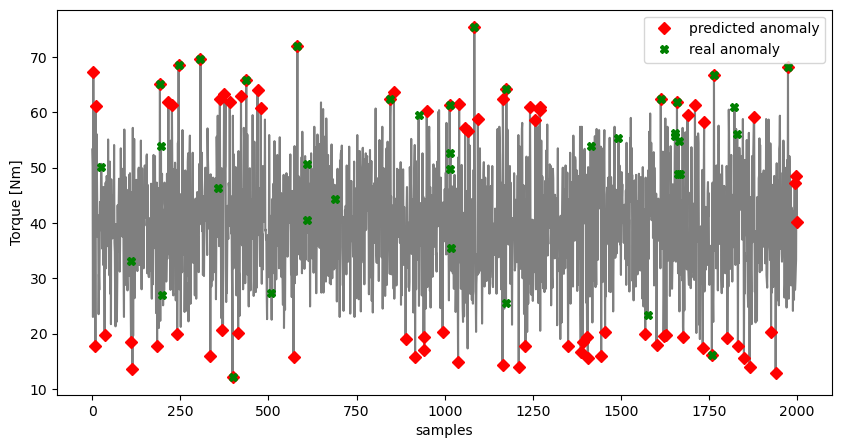

accuracy: 0.955
confusion matrix:
 [[1895   66]
 [  24   15]]


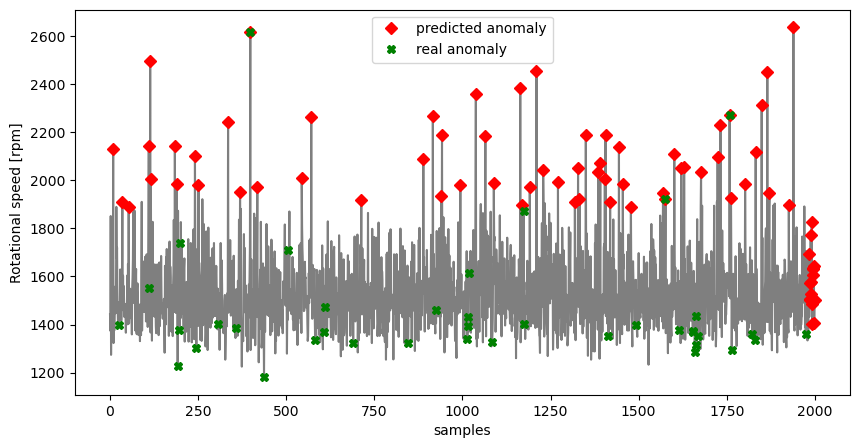

accuracy: 0.9455
confusion matrix:
 [[1888   73]
 [  36    3]]


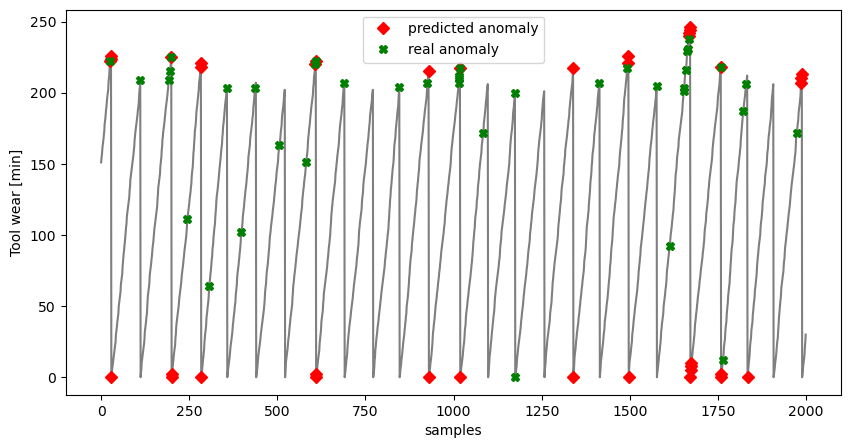

accuracy: 0.9675
confusion matrix:
 [[1929   32]
 [  33    6]]


In [15]:
show_search_anomalies(df, idx_split, 'Torque [Nm]')
show_search_anomalies(df, idx_split, 'Rotational speed [rpm]')
show_search_anomalies(df, idx_split, 'Tool wear [min]')

In [16]:
import numpy as np
def test_search_anomalies():
    data=np.array([10, 10, 10, 10, 30, 20, 10, 10]) 
    predicted=search_anomalies(data, 2)
    assert predicted[1]==0
    assert predicted[4]==1
    assert predicted[5]==1 
test_search_anomalies()

## Version 2 with ML and ARIMA

In [17]:
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot
import numpy as np
from sklearn.svm import OneClassSVM
def ARIMA_residuals(series): 
    # fit model 
    model = ARIMA(series, order=(5,1,3)) 
    model_fit = model.fit() 
    print(model_fit.summary()) 
    
    # plot residual errors 
    residuals = pd.DataFrame(model_fit.resid)  
    
    return residuals.T 

  
def search_anomalies_OCSVM(X_train, X_test): 
    clf = OneClassSVM(kernel="rbf", tol=0.0001, nu=0.1).fit(X_train)
    y_pred = clf.predict(X_test) 
    anomalies=[ 0 if _x > 0 else 1 for _x in y_pred] 
    return np.array(anomalies)

In [18]:
residuals =[]
for name in X_columns:
    residuals.append(ARIMA_residuals(df[name]))

X_residual=np.vstack(residuals).T 
anomalies=search_anomalies_OCSVM(X_residual, X_residual)

/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                SARIMAX Results                                
Dep. Variable:     Air temperature [K]   No. Observations:                10000
Model:                  ARIMA(5, 1, 3)   Log Likelihood               12776.031
Date:                 Wed, 17 Jul 2024   AIC                         -25534.061
Time:                         13:00:14   BIC                         -25469.169
Sample:                              0   HQIC                        -25512.095
                               - 10000                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0804      0.750     -0.107      0.915      -1.550       1.389
ar.L2         -0.0069      0.704     -0.010      0.992      -1.387       1.373
ar.L3          0.0037      0.697      0.005 

/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                SARIMAX Results                                 
Dep. Variable:     Diff temperature [K]   No. Observations:                10000
Model:                   ARIMA(5, 1, 3)   Log Likelihood               12897.601
Date:                  Wed, 17 Jul 2024   AIC                         -25777.202
Time:                          13:00:19   BIC                         -25712.310
Sample:                               0   HQIC                        -25755.236
                                - 10000                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1838     19.257     -0.010      0.992     -37.926      37.559
ar.L2         -0.0417      7.855     -0.005      0.996     -15.438      15.354
ar.L3         -0.0197      1.338    

/opt/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                 SARIMAX Results                                  
Dep. Variable:     Rotational speed [rpm]   No. Observations:                10000
Model:                     ARIMA(5, 1, 3)   Log Likelihood              -66128.300
Date:                    Wed, 17 Jul 2024   AIC                         132274.600
Time:                            13:00:31   BIC                         132339.492
Sample:                                 0   HQIC                        132296.566
                                  - 10000                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8496      0.015    -55.279      0.000      -0.880      -0.820
ar.L2         -0.9649      0.019    -51.797      0.000      -1.001      -0.928
ar.L3          0.014

/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:            Torque [Nm]   No. Observations:                10000
Model:                 ARIMA(5, 1, 3)   Log Likelihood              -37185.260
Date:                Wed, 17 Jul 2024   AIC                          74388.521
Time:                        13:00:42   BIC                          74453.413
Sample:                             0   HQIC                         74410.487
                              - 10000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4852      0.065    -22.749      0.000      -1.613      -1.357
ar.L2         -0.9265      0.065    -14.235      0.000      -1.054      -0.799
ar.L3          0.0331      0.020      1.641      0.1

/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:        Tool wear [min]   No. Observations:                10000
Model:                 ARIMA(5, 1, 3)   Log Likelihood              -45666.835
Date:                Wed, 17 Jul 2024   AIC                          91351.669
Time:                        13:00:58   BIC                          91416.562
Sample:                             0   HQIC                         91373.635
                              - 10000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8807      0.304     -2.896      0.004      -1.477      -0.285
ar.L2          0.8084      0.211      3.824      0.000       0.394       1.223
ar.L3          0.8676      0.306      2.839      0.0

/opt/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                   Type   No. Observations:                10000
Model:                 ARIMA(5, 1, 3)   Log Likelihood              -10205.522
Date:                Wed, 17 Jul 2024   AIC                          20429.044
Time:                        13:01:10   BIC                          20493.936
Sample:                             0   HQIC                         20451.009
                              - 10000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2614      0.053    -24.002      0.000      -1.364      -1.158
ar.L2         -0.9525      0.053    -17.846      0.000      -1.057      -0.848
ar.L3         -0.0013      0.019     -0.070      0.9

(-1.0, 1.0)

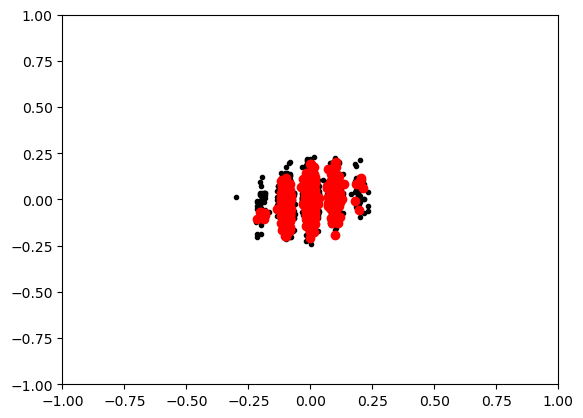

In [19]:
plt.plot(X_residual[:,0],X_residual[:,1],'k.')
plt.plot(X_residual[anomalies==1,0], X_residual[anomalies==1,1],'ro')
plt.xlim(-1,1)
plt.ylim(-1,1)

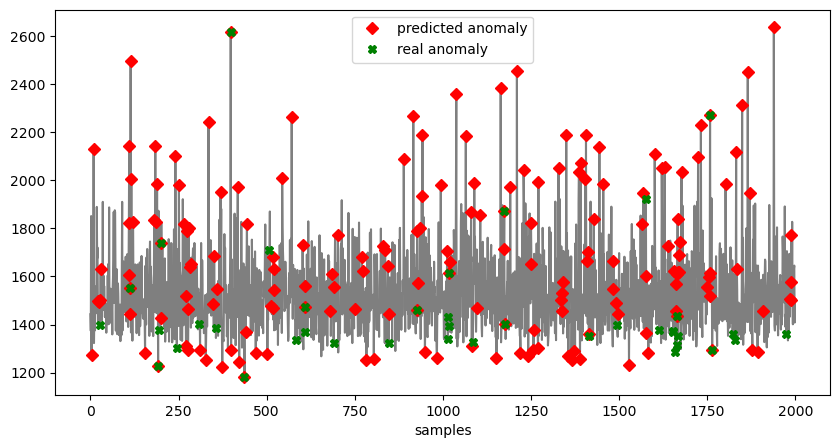

accuracy: 0.905
confusion matrix:
 [[1797  164]
 [  26   13]]


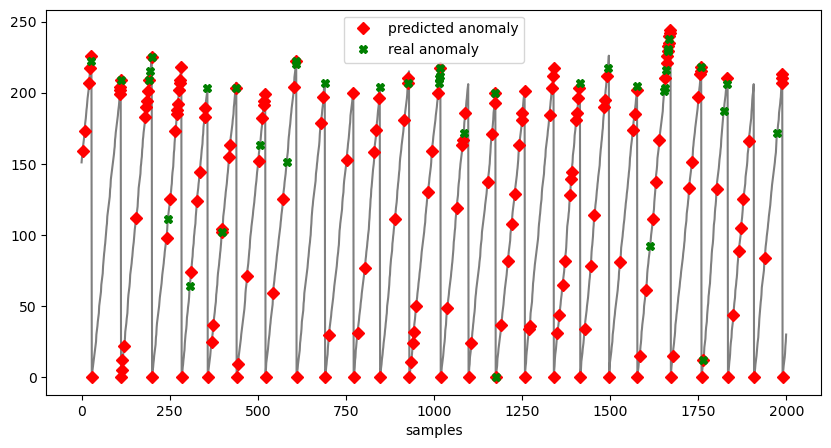

accuracy: 0.905
confusion matrix:
 [[1797  164]
 [  26   13]]


In [20]:
#showing results
show_anomalies(X[idx_split:,2], y[idx_split:], anomalies[idx_split:])
show_anomalies(X[idx_split:,4], y[idx_split:], anomalies[idx_split:])


## Version 3 with isolation Forest

In [21]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(contamination='auto')
clf.fit(X_train)

IsolationForest()

In [22]:
anomalies = clf.predict(X_test)
anomalies = np.array([1 if _x < 0  else 0 for _x in anomalies]) 

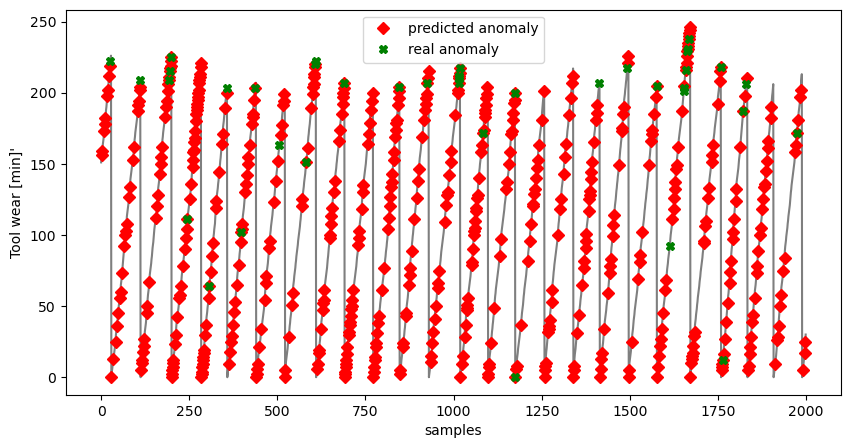

accuracy: 0.725
confusion matrix:
 [[1422  539]
 [  11   28]]


In [23]:
show_anomalies(X_test[:,4], y_test, anomalies, title="Tool wear [min]'")

# PYOD

In [24]:
from pyod.models.inne import INNE
clf = INNE()
clf.fit(X_train)

INNE(contamination=0.1, max_samples='auto', n_estimators=200,
   random_state=None)

In [25]:
anomalies = clf.predict(X_test)
print(f'found {np.sum(anomalies)} anomalies')

found 166 anomalies


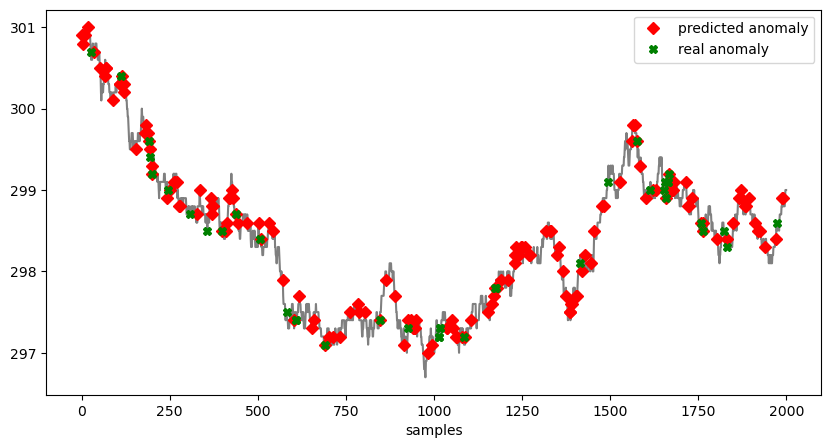

accuracy: 0.9105
confusion matrix:
 [[1808  153]
 [  26   13]]


In [26]:
show_anomalies(X_test[:,0], y_test, anomalies)